In [2]:
import os
os.environ['PROJ_LIB'] = '/data/keeling/a/sshu3/anaconda2/share/proj'
from mpl_toolkits.basemap import Basemap, cm, shiftgrid,maskoceans
from netCDF4 import Dataset as NetCDFFile
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy.ma as ma
from scipy.interpolate import griddata
from pyresample import geometry,image, kd_tree
import mycolorbars


In [38]:
## Scatter plot for showing the correlation btw env factor and wetland CH4 emission.
## Historical
# Get CH4 fluxes
#nclu=NetCDFFile('hist_01_10.nc','r')
path = '/data/jain1/c/sshu3/SBGC/results/AGU2019/hist/'
fname = 'Trendy_spinup.bgc-yearly-2d_2008.nc'
nclu=NetCDFFile(path+fname,'r')
ncvar_flux = nclu.variables['ch4_flux'][:]
ncvar_nonwtld = nclu.variables['ch4_flux_dry'][:]
ncvar_wtld = nclu.variables['ch4_flux_wet'][:]
ncvar_inund = nclu.variables['ch4_flux_inund'][:]
ncvar_wtld_prod = nclu.variables['ch4_prod_wet'][:]
ncvar_inund_prod = nclu.variables['ch4_prod_inund'][:]

latnc = nclu.variables['lat'][:]
lonnc = nclu.variables['lon'][:]
lonnc = ((lonnc - 180) % 360) - 180
ncvar_wetland = ncvar_wtld + ncvar_inund
ncvar_wetland_prod = ncvar_wtld_prod + ncvar_inund_prod

nclu.close()

## RCP45
path = '/data/jain1/c/sshu3/SBGC/results/AGU2019/rcp45/'
fname = 'Trendy_spinup.bgc-yearly-2d_2099.nc'
nclu=NetCDFFile(path+fname,'r')
ncvar_flux_45 = nclu.variables['ch4_flux'][:]
ncvar_nonwtld_45 = nclu.variables['ch4_flux_dry'][:]
ncvar_wtld_45 = nclu.variables['ch4_flux_wet'][:]
ncvar_inund_45 = nclu.variables['ch4_flux_inund'][:]
ncvar_wtld_prod_45 = nclu.variables['ch4_prod_wet'][:]
ncvar_inund_prod_45 = nclu.variables['ch4_prod_inund'][:]

ncvar_wetland_45 = ncvar_wtld_45 + ncvar_inund_45
ncvar_wetland_prod_45 = ncvar_wtld_prod_45 + ncvar_inund_prod_45

nclu.close()

## RCP85
path = '/data/jain1/c/sshu3/SBGC/results/AGU2019/rcp85/'
fname = 'Trendy_spinup.bgc-yearly-2d_2099.nc'
nclu=NetCDFFile(path+fname,'r')
ncvar_flux_85 = nclu.variables['ch4_flux'][:]
ncvar_nonwtld_85 = nclu.variables['ch4_flux_dry'][:]
ncvar_wtld_85 = nclu.variables['ch4_flux_wet'][:]
ncvar_inund_85 = nclu.variables['ch4_flux_inund'][:]
ncvar_wtld_prod_85 = nclu.variables['ch4_prod_wet'][:]
ncvar_inund_prod_85 = nclu.variables['ch4_prod_inund'][:]

ncvar_wetland_85 = ncvar_wtld_85 + ncvar_inund_85
ncvar_wetland_prod_85 = ncvar_wtld_prod_85 + ncvar_inund_prod_85

nclu.close()

# Get inundated fraction
path = '/data/jain1/c/sshu3/SBGC/results/AGU2019/hist/'
fname = 'Trendy_spinup.ISAM_GCP_METHANE_2008.nc'
nclu_fw=NetCDFFile(path+fname,'r')
fw_m = nclu_fw.variables['fw_m'][:]
fw = np.nanmean(fw_m, axis=0)
nclu_fw.close()

path = '/data/jain1/c/sshu3/SBGC/results/AGU2019/rcp45/'
fname = 'Trendy_spinup.ISAM_GCP_METHANE_2099.nc'
nclu_fw=NetCDFFile(path+fname,'r')
fw_m_45 = nclu_fw.variables['fw_m'][:]
fw_45 = np.nanmean(fw_m_45, axis=0)
nclu_fw.close()

path = '/data/jain1/c/sshu3/SBGC/results/AGU2019/rcp85/'
fname = 'Trendy_spinup.ISAM_GCP_METHANE_2099.nc'
nclu_fw=NetCDFFile(path+fname,'r')
fw_m_85 = nclu_fw.variables['fw_m'][:]
fw_85 = np.nanmean(fw_m_85, axis=0)
nclu_fw.close()

# Get Environmental factors (Tair and Precip)
# Hist
path = '/data/jain1/c/sshu3/SBGC/results/AGU2019/hist/'
fname = 'Trendy_spinup.bgp-yearly_2d_2008.nc'
nclu_env=NetCDFFile(path+fname,'r')
ncvar_temp = nclu_env.variables['tavg_avg_yr'][:]
ncvar_prec = nclu_env.variables['precip_avg_yr'][:]
#ncvar_wliq = nclu_env.variables['wliq_vol_1m_yr'][:]
ncvar_wliq = nclu_env.variables['sm_1_5_avg_yr'][:]
nclu_env.close()

# RCP45
path = '/data/jain1/c/sshu3/SBGC/results/AGU2019/rcp45/'
fname = 'Trendy_spinup.bgp-yearly_2d_2099.nc'
nclu_env=NetCDFFile(path+fname,'r')
ncvar_temp_45 = nclu_env.variables['tavg_avg_yr'][:]
ncvar_prec_45 = nclu_env.variables['precip_avg_yr'][:]
#ncvar_wliq_45 = nclu_env.variables['wliq_vol_1m_yr'][:]
ncvar_wliq_45 = nclu_env.variables['sm_1_5_avg_yr'][:]
nclu_env.close()

# RCP85
path = '/data/jain1/c/sshu3/SBGC/results/AGU2019/rcp85/'
fname = 'Trendy_spinup.bgp-yearly_2d_2099.nc'
nclu_env=NetCDFFile(path+fname,'r')
ncvar_temp_85 = nclu_env.variables['tavg_avg_yr'][:]
ncvar_prec_85 = nclu_env.variables['precip_avg_yr'][:]
#ncvar_wliq = nclu_env.variables['wliq_vol_1m_yr'][:]
ncvar_wliq_85 = nclu_env.variables['sm_1_5_avg_yr'][:]
nclu_env.close()

# Mask out specific regions to get some numbers
ncmk=NetCDFFile('surfdata_05x05_13reg.nc','r')
ncvar_mask = ncmk.variables['REGION_MASK_CRU_NCEP'][:]

#ncvar_nonwtld[ncvar_mask<12] = ma.masked  #ncvar_net*ncvar_mask
#ncvar_nonwtld[ncvar_mask>12] = ma.masked  #ncvar_net*ncvar_mask
#ncvar_wetland[ncvar_mask>12] = ma.masked  #ncvar2_net*ncvar_mask
#ncvar_wetland[ncvar_mask<12] = ma.masked  #ncvar3_net*ncvar_mask

#ncvar2_nonwtld[ncvar_mask<12] = ma.masked  #ncvar_net*ncvar_mask
#ncvar2_nonwtld[ncvar_mask>12] = ma.masked  #ncvar_net*ncvar_mask
#ncvar2_wetland[ncvar_mask<12] = ma.masked  #ncvar2_net*ncvar_mask
#ncvar2_wetland[ncvar_mask>12] = ma.masked  #ncvar2_net*ncvar_mask

#ncvar3_nonwtld[ncvar_mask<12] = ma.masked  #ncvar_net*ncvar_mask
#ncvar3_nonwtld[ncvar_mask>12] = ma.masked  #ncvar_net*ncvar_mask
#ncvar3_wetland[ncvar_mask<12] = ma.masked  #ncvar2_net*ncvar_mask
#ncvar3_wetland[ncvar_mask>12] = ma.masked  #ncvar2_net*ncvar_mask

#ncvar_temp[ncvar_mask<12] = ma.masked  #ncvar_net*ncvar_mask
#ncvar_temp[ncvar_mask>12] = ma.masked  #ncvar_net*ncvar_mask
#ncvar2_temp[ncvar_mask<12] = ma.masked  #ncvar2_net*ncvar_mask
#ncvar2_temp[ncvar_mask>12] = ma.masked  #ncvar2_net*ncvar_mask
#ncvar3_temp[ncvar_mask<12] = ma.masked  #ncvar2_net*ncvar_mask
#ncvar3_temp[ncvar_mask>12] = ma.masked  #ncvar2_net*ncvar_mask

#ncvar_prec[ncvar_mask<12] = ma.masked  #ncvar_net*ncvar_mask
#ncvar_prec[ncvar_mask>12] = ma.masked  #ncvar_net*ncvar_mask
#ncvar2_prec[ncvar_mask<12] = ma.masked  #ncvar2_net*ncvar_mask
#ncvar2_prec[ncvar_mask>12] = ma.masked  #ncvar2_net*ncvar_mask
#ncvar3_prec[ncvar_mask<12] = ma.masked  #ncvar2_net*ncvar_mask
#ncvar3_prec[ncvar_mask>12] = ma.masked  #ncvar2_net*ncvar_mask

#fw[ncvar_mask<12] = ma.masked  #ncvar_net*ncvar_mask
#fw[ncvar_mask>12] = ma.masked  #ncvar_net*ncvar_mask
#fw2[ncvar_mask<12] = ma.masked  #ncvar2_net*ncvar_mask
#fw2[ncvar_mask>12] = ma.masked  #ncvar2_net*ncvar_mask
#fw3[ncvar_mask<12] = ma.masked  #ncvar2_net*ncvar_mask
#fw3[ncvar_mask>12] = ma.masked  #ncvar2_net*ncvar_mask

#ncvar_wliq[ncvar_mask<12] = ma.masked  #ncvar_net*ncvar_mask
#ncvar_wliq[ncvar_mask>12] = ma.masked  #ncvar_net*ncvar_mask
#ncvar2_wliq[ncvar_mask<12] = ma.masked  #ncvar2_net*ncvar_mask
#ncvar2_wliq[ncvar_mask>12] = ma.masked  #ncvar2_net*ncvar_mask
#ncvar3_wliq[ncvar_mask<12] = ma.masked  #ncvar2_net*ncvar_mask
#ncvar3_wliq[ncvar_mask>12] = ma.masked  #ncvar2_net*ncvar_mask

In [39]:
# Diff between historical case and future case
temp_diff_85 = ncvar_temp_85 - ncvar_temp
temp_diff_45 = ncvar_temp_45 - ncvar_temp
prec_diff_85 = ncvar_prec_85 - ncvar_prec
prec_diff_45 = ncvar_prec_45 - ncvar_prec
wetland_diff_85 =  ncvar_wetland_85 - ncvar_wetland
wetland_diff_45 =  ncvar_wetland_45 - ncvar_wetland
fw_diff_85 = fw_85 - fw
fw_diff_45 = fw_45 - fw


In [8]:
np.shape(tt)

(360, 720)

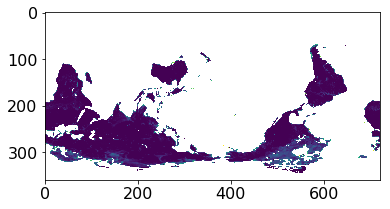

In [18]:
plt.imshow(fw_85)

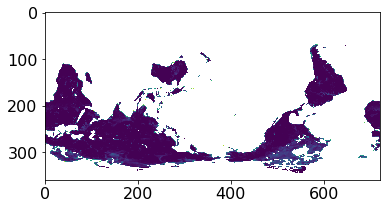

In [19]:
plt.imshow(fw)

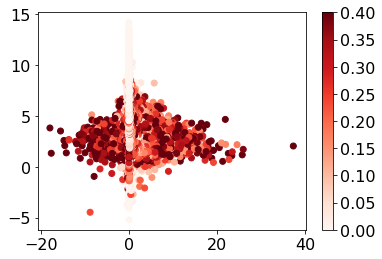

In [15]:
# Prepare scatter plot
plt.rcParams.update({'font.size': 16})
plt.scatter(wetland_diff_85, temp_diff_85, c=fw, vmin=0, vmax=0.4, cmap=plt.cm.Reds)
plt.colorbar()
plt.show()

y=0.026950x+(1.534694)


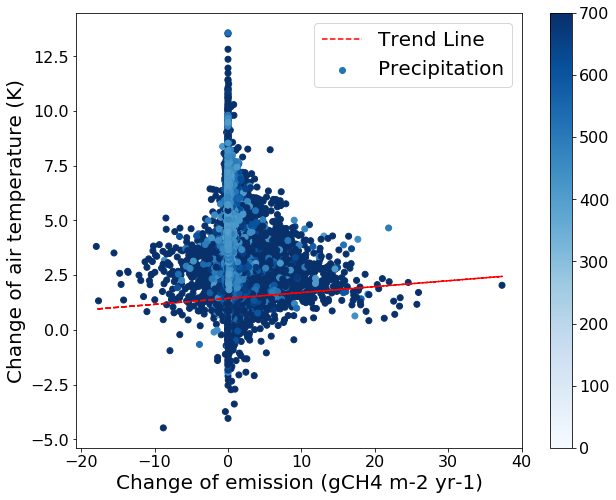

In [55]:
fig = plt.figure(figsize=(10,8))
# Prepare scatter plot
selx = wetland_diff_85[ncvar_prec>400]
sely = temp_diff_85[ncvar_prec>400]
selc = ncvar_prec[ncvar_prec>400]
newx = selx[abs(selx)!=0]
newy = sely[abs(selx)!=0]
newc = selc[abs(selx)!=0]
plt.rcParams.update({'font.size': 16})
plt.scatter(selx, sely, c=selc, vmin=0, vmax=700, cmap=plt.cm.Blues)
plt.colorbar()
# plot the data itself

# calc the trendline
# z = np.polyfit(newx, newy, 1)
# p = np.poly1d(z)
plt.plot(newx, p(newx)-0.1, "r--")
# the line equation:
print "y=%.6fx+(%.6f)"%(z[0],z[1])

ybar = np.sum(sely)/len(sely)          # or sum(y)/len(y)
ssreg = np.sum((p(selx)-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
sstot = np.sum((sely - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
r_sqrt = ssreg / sstot

plt.xlabel('Change of emission (gCH4 m-2 yr-1)', fontsize=20)
plt.ylabel('Change of air temperature (K)', fontsize=20)
plt.legend(['Trend Line', 'Precipitation'], fontsize=20)

#plt.show()
plt.savefig('fig_rcp85_temp.png')

y=0.003982x+(0.292198)


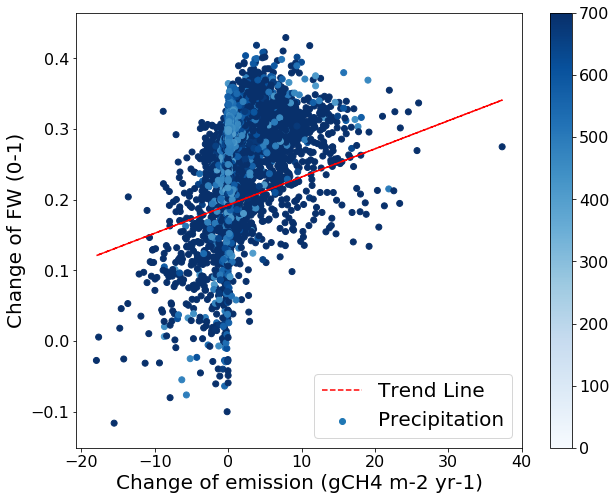

In [36]:
fig = plt.figure(figsize=(10,8))
# Prepare scatter plot
selx = wetland_diff_85[ncvar_prec>400]
sely = fw_diff_85[ncvar_prec>400]+0.3
selc = ncvar_prec[ncvar_prec>400]
newx = selx[abs(selx)!=0]
newy = sely[abs(selx)!=0]
newc = selc[abs(selx)!=0]
plt.rcParams.update({'font.size': 16})
plt.scatter(newx, newy, c=newc, vmin=0, vmax=700, cmap=plt.cm.Blues)
plt.colorbar()
# plot the data itself

# calc the trendline
z = np.polyfit(newx, newy, 1)
p = np.poly1d(z)
plt.plot(newx, p(newx)-0.1, "r--")
# the line equation:
print "y=%.6fx+(%.6f)"%(z[0],z[1])

ybar = np.sum(newy)/len(newy)          # or sum(y)/len(y)
ssreg = np.sum((p(newx)-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
sstot = np.sum((newy - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
r_sqrt = ssreg / sstot

plt.xlabel('Change of emission (gCH4 m-2 yr-1)', fontsize=20)
plt.ylabel('Change of FW (0-1)', fontsize=20)
plt.legend(['Trend Line', 'Precipitation'], fontsize=20)

#plt.show()
plt.savefig('fig_rcp85_fw.png')

y=0.026950x+(1.534694)


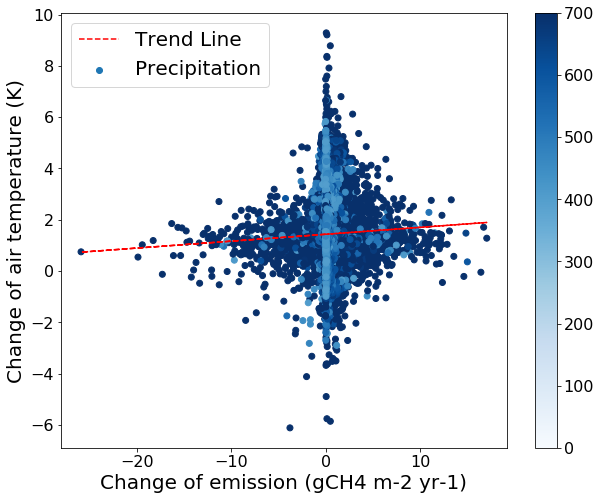

In [53]:
fig = plt.figure(figsize=(10,8))
# Prepare scatter plot
selx = wetland_diff_45[ncvar_prec>400]
sely = temp_diff_45[ncvar_prec>400]
selc = ncvar_prec[ncvar_prec>400]
newx = selx[abs(selx)!=0]
newy = sely[abs(selx)!=0]
newc = selc[abs(selx)!=0]
plt.rcParams.update({'font.size': 16})
plt.scatter(newx, newy, c=newc, vmin=0, vmax=700, cmap=plt.cm.Blues)
plt.colorbar()
# plot the data itself

# calc the trendline
z = np.polyfit(newx, newy, 1)
p = np.poly1d(z)
plt.plot(newx, p(newx)-0.1, "r--")
# the line equation:
print "y=%.6fx+(%.6f)"%(z[0],z[1])

ybar = np.sum(newy)/len(newy)          # or sum(y)/len(y)
ssreg = np.sum((p(newx)-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
sstot = np.sum((newy - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
r_sqrt = ssreg / sstot

plt.xlabel('Change of emission (gCH4 m-2 yr-1)', fontsize=20)
plt.ylabel('Change of air temperature (K)', fontsize=20)
plt.legend(['Trend Line', 'Precipitation'], fontsize=20)

#plt.show()
plt.savefig('fig_rcp45_temp.png')

y=0.013053x+(0.141679)


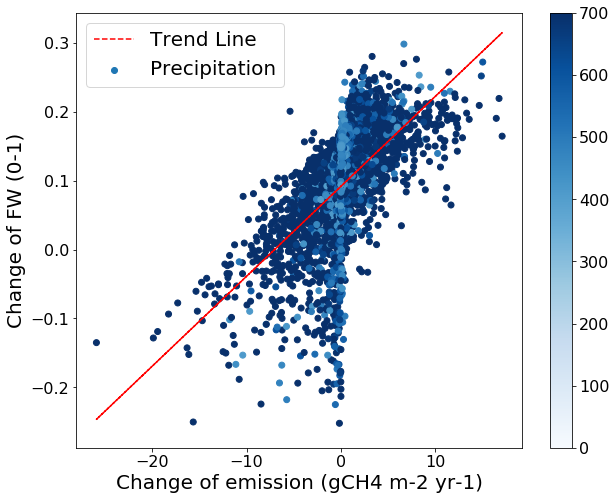

In [46]:
fig = plt.figure(figsize=(10,8))
# Prepare scatter plot
selx = wetland_diff_45[ncvar_prec>400]
sely = fw_diff_45[ncvar_prec>400]+0.15
selc = ncvar_prec[ncvar_prec>400]
newx = selx[abs(selx)!=0]
newy = sely[abs(selx)!=0]
newc = selc[abs(selx)!=0]
plt.rcParams.update({'font.size': 16})
plt.scatter(newx, newy, c=newc, vmin=0, vmax=700, cmap=plt.cm.Blues)
plt.colorbar()
# plot the data itself

# calc the trendline
z = np.polyfit(newx, newy, 1)
p = np.poly1d(z)
plt.plot(newx, p(newx)-0.05, "r--")
# the line equation:
print "y=%.6fx+(%.6f)"%(z[0],z[1])

ybar = np.sum(newy)/len(newy)          # or sum(y)/len(y)
ssreg = np.sum((p(newx)-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
sstot = np.sum((newy - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
r_sqrt = ssreg / sstot

plt.xlabel('Change of emission (gCH4 m-2 yr-1)', fontsize=20)
plt.ylabel('Change of FW (0-1)', fontsize=20)
plt.legend(['Trend Line', 'Precipitation'], fontsize=20)

#plt.show()
plt.savefig('fig_rcp45_fw.png')

In [ ]:
# Prepare scatter plot
plt.rcParams.update({'font.size': 16})
plt.scatter(ncvar_wetland, fw, c=ncvar_temp, vmin=250, vmax=280, cmap=plt.cm.Blues)
plt.colorbar()
plt.show()
#plt.savefig('figs5a.png')

In [ ]:
# Prepare scatter plot
plt.rcParams.update({'font.size': 16})
plt.scatter(ncvar_nonwtld[ncvar_nonwtld<1.0], ncvar_wliq[ncvar_nonwtld<1.0]*100, c=ncvar_temp[ncvar_nonwtld<1.0], vmin=250, vmax=280, cmap=plt.cm.Reds)
plt.xlim([-3,3])
plt.axvline(x=0.0)
plt.colorbar()
#plt.show()
plt.savefig('nonwetlandch4_vs_sm_ctemp.jpg')

In [ ]:
# The following cells are for analyzing the RCP4.5 projection.
diff_wetland = ncvar2_wetland - ncvar_wetland
diff_nonwtld = ncvar2_nonwtld - ncvar_nonwtld
diff_wetland_prod = ncvar2_wetland_prod - ncvar_wetland_prod
diff_fw = fw2 - fw
diff_temp = ncvar2_temp - ncvar_temp
diff_prec = ncvar2_prec - ncvar_prec
diff_wliq = ncvar2_wliq - ncvar_wliq

In [ ]:
# Prepare scatter plot
plt.rcParams.update({'font.size': 16})
plt.scatter(diff_wetland, diff_fw, c=diff_temp, vmin=1, vmax=2.5, cmap=plt.cm.Reds)
plt.colorbar()
plt.show()

In [ ]:
# Prepare scatter plot
plt.rcParams.update({'font.size': 16})
plt.scatter(diff_wetland[abs(ncvar2_wetland)>0.3], diff_temp[abs(ncvar2_wetland)>0.3])  #, c=diff_temp, vmin=-0.1, vmax=0.1, cmap=plt.cm.Reds)
#plt.colorbar()
plt.show()

In [ ]:
# Prepare scatter plot
plt.rcParams.update({'font.size': 16})
plt.scatter(diff_wetland, diff_prec)  #, c=diff_temp, vmin=-0.1, vmax=0.1, cmap=plt.cm.Reds)
#plt.colorbar()
plt.show()

In [ ]:
# Prepare scatter plot
plt.rcParams.update({'font.size': 16})
plt.scatter(diff_nonwtld, diff_wliq)  #, c=diff_temp, vmin=-0.1, vmax=0.1, cmap=plt.cm.Reds)
#plt.colorbar()
plt.show()

In [ ]:
# The following cells are for analyzing the RCP8.5 projection.
diff_wetland = ncvar3_wetland - ncvar_wetland
diff_nonwtld = ncvar3_nonwtld - ncvar_nonwtld
diff_wetland_prod = ncvar3_wetland_prod - ncvar_wetland_prod
diff_fw = fw3 - fw
diff_temp = ncvar3_temp - ncvar_temp
diff_prec = ncvar3_prec - ncvar_prec
diff_wliq = ncvar3_wliq - ncvar_wliq

In [ ]:
# Prepare scatter plot
plt.rcParams.update({'font.size': 16})
plt.scatter(diff_wetland, diff_fw, c=diff_temp, vmin=3, vmax=6, cmap=plt.cm.Reds)
plt.colorbar()
plt.show()

In [ ]:
# Prepare scatter plot
plt.rcParams.update({'font.size': 16})
plt.scatter(diff_wetland, diff_wetland_prod)  #, c=diff_temp, vmin=-0.1, vmax=0.1, cmap=plt.cm.Reds)
#plt.colorbar()
plt.show()

In [ ]:
# Prepare scatter plot
plt.rcParams.update({'font.size': 16})
plt.scatter(diff_wetland, diff_prec)  #, c=diff_temp, vmin=-0.1, vmax=0.1, cmap=plt.cm.Reds)
#plt.colorbar()
plt.show()

In [ ]:
# Prepare scatter plot
plt.rcParams.update({'font.size': 16})
plt.scatter(diff_nonwtld, diff_wliq)  #, c=diff_temp, vmin=-0.1, vmax=0.1, cmap=plt.cm.Reds)
#plt.colorbar()
plt.show()

In [ ]:
# Prepare scatter plot
plt.rcParams.update({'font.size': 16})
plt.scatter(ncvar3_nonwtld, ncvar3_wliq, c=ncvar3_temp, vmin=260, vmax=300, cmap=plt.cm.Reds)
#plt.colorbar()
plt.show()